In [1]:
import numpy as np
import scipy
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [2]:
X, y = load_iris(return_X_y=True)
X = StandardScaler().fit_transform(X)
n = X.shape[0]
X = np.hstack((X, np.ones((n, 1))))
p = X.shape[1]

In [3]:
def compute_u_vector(xi, w):
    p = len(xi)
    num_classes = len(w) // len(xi)
    result = np.zeros(num_classes)
    for k in range(num_classes):
        wk = w[p*k:p*(k+1)]
        result[k] = np.dot(wk, xi)
    return result

In [4]:
def compute_loss(yi, u_vector):
    exp_u_vector = np.exp(u_vector)
    return -(u_vector[yi] - np.log(np.sum(exp_u_vector)))

## Gradient

In [5]:
def compute_loss_gradient(xi, yi, w):
    p = len(xi)
    num_classes = len(w) // p
    u_vector = compute_u_vector(xi, w)
    exp_u_vector = np.exp(u_vector)
    normalizer = np.sum(exp_u_vector)
    result = np.zeros(num_classes)
    for k in range(num_classes):
        result[k] = float(k == yi) - exp_u_vector[k] / normalizer
    return -result

## Hessian

In [6]:
def compute_loss_hessian(xi, yi, w):
    p = len(xi)
    num_classes = len(w) // p
    u_vector = compute_u_vector(xi, w)
    exp_u_vector = np.exp(u_vector)
    normalizer = np.sum(exp_u_vector)
    result = np.zeros((num_classes, num_classes))
    for k1 in range(num_classes):
        for k2 in range(k1 + 1):
            result[k1, k2] = exp_u_vector[k1]*exp_u_vector[k2] / normalizer**2
            if k1 == k2:
                result[k1, k2] -= exp_u_vector[k1] / normalizer
            result[k2, k1] = result[k1, k2]
    return -result

In [7]:
def compute_hessian(X, y, w, C):
    p = X.shape[1]
    num_classes = len(w) // X.shape[1]
    result = np.zeros((len(w), len(w)))
    for i, (xi, yi) in enumerate(zip(X, y)):
        loss_hess = compute_loss_hessian(xi, yi, w)
        for index1 in range(len(w)):
            for index2 in range(index1+1):
                k1 = index1 // p
                j1 = index1 % p
                k2 = index2 // p
                j2 = index2 % p
                result[index1, index2] += loss_hess[k1, k2]*xi[j1]*xi[j2]
                result[index2, index1] = result[index1, index2]
    alpha = 1 / (2*C)
    for index in range(len(w)):
        result[index, index] += 2*alpha
    return result

## ALO

In [8]:
def compute_Z_i(xi, num_classes):
    p = len(xi)
    result = np.zeros((p*num_classes, num_classes))
    for k in range(num_classes):
        result[p*k:p*(k+1), k] = xi
    return result

In [9]:
def compute_K_i(L, xi, num_classes):
    Z_i = compute_Z_i(xi, num_classes)
    T_i = scipy.linalg.solve_triangular(L, Z_i, lower=True)
    return np.dot(T_i.T, T_i)

In [10]:
def compute_u_mi_vector(L, xi, yi, w):
    num_classes = len(w) // len(xi)
    loss_grad = compute_loss_gradient(xi, yi, w)
    loss_hess = compute_loss_hessian(xi, yi, w)
    u_i = compute_u_vector(xi, w)
    K_i = compute_K_i(L, xi, num_classes)
    inner = np.identity(num_classes) - np.dot(loss_hess, K_i)
    
    delta_vector = np.linalg.solve(inner, loss_grad)
    delta_vector = np.dot(K_i, delta_vector)
    
    return u_i + delta_vector

In [11]:
def compute_alo(X, y, C):
    w = LogisticRegression(fit_intercept=False, C=C).fit(X, y).coef_.flatten()
    H = compute_hessian(X, y, w, C)
    L = np.linalg.cholesky(H)
    num_classes = len(w) // X.shape[1]
    result = 0
    for i, (xi, yi) in enumerate(zip(X, y)):
        u_mi_vector = compute_u_mi_vector(L, xi, yi, w)
        result += -compute_loss(yi, u_mi_vector)
    return result / len(y)

## LO

In [12]:
def compute_lo(X, y, C):
    model = LogisticRegression(fit_intercept=False, C=C)
    result = 0
    labels = np.array(set(y))
    for train_indexes, test_indexes in LeaveOneOut().split(X):
        X_train = X[train_indexes]
        y_train = y[train_indexes]
        X_test = X[test_indexes]
        y_test = y[test_indexes]
        model.fit(X_train, y_train)
        pred = model.predict_log_proba(X_test)[0]
        result += pred[y_test[0]]
    return result / len(y)

## Testing

In [13]:
alphas = np.arange(0.001, .05, 0.001)
alos = [compute_alo(X, y, 1 / (2*alpha)) for alpha in alphas]
los = [compute_lo(X, y, 1/(2*alpha)) for alpha in alphas]

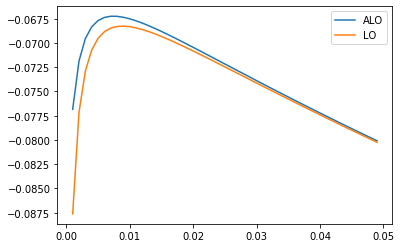

In [14]:
plt.plot(alphas, alos, label='ALO')
plt.plot(alphas, los, label='LO')
plt.legend()